# OnlineNewsPopularity Classification
<hr>

In this example we would be dealing with the Online News Popularity dataset. This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years. The goal is to predict the number of shares in social networks (popularity).

The dataset can be downloaded from : https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity

- [Optimization](#Optimization)
- [Ensemble Learning](# Ensemble Learning)


In [2]:
import os
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from time import time
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score , classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


In [3]:
# read .csv from provided dataset
csv_filename="datasets/OnlineNewsPopularity.csv"

# df=pd.read_csv(csv_filename,index_col=0)
df=pd.read_csv(csv_filename)

# handle goal attrubte to binary
popular = df.shares >= 1400
unpopular = df.shares < 1400
df.loc[popular,'shares'] = 1
df.loc[unpopular,'shares'] = 0

In [76]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731,12,219,0.663594,1.0,0.815385,4,2,1,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731,9,255,0.604743,1.0,0.791946,3,1,1,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0
2,http://mashable.com/2013/01/07/apple-40-billio...,731,9,211,0.575130,1.0,0.663866,3,1,1,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1
3,http://mashable.com/2013/01/07/astronaut-notre...,731,9,531,0.503788,1.0,0.665635,9,0,1,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.415646,1.0,0.540890,19,19,20,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0


In [77]:
features=list(df.columns[2:60])

# split dataset to 60% training and 40% testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(df[features], df['shares'], test_size=0.4, random_state=0)

In [78]:
print X_train.shape, y_train.shape

(23786, 58) (23786L,)


### Feature importances with forests of trees

This examples shows the use of forests of trees to evaluate the importance of features on an artificial classification task. The red bars are the feature importances of the forest, along with their inter-trees variability.

In [79]:
X = df[features]
y= df['shares']

Feature ranking:
1. feature 39 - LDA_02 (0.030305) 
2. feature 25 - kw_avg_avg (0.026984) 
3. feature 23 - kw_min_avg (0.026983) 
4. feature 38 - LDA_01 (0.023589) 
5. feature 37 - LDA_00 (0.023188) 
6. feature 24 - kw_max_avg (0.022944) 
7. feature 40 - LDA_03 (0.022731) 
8. feature 41 - LDA_04 (0.022693) 
9. feature 22 - kw_avg_max (0.022342) 
10. feature 5 - num_hrefs (0.021784) 
11. feature 0 - n_tokens_title (0.021752) 
12. feature 2 - n_unique_tokens (0.021663) 
13. feature 42 - global_subjectivity (0.021505) 
14. feature 4 - n_non_stop_unique_tokens (0.021418) 
15. feature 10 - num_keywords (0.021359) 
16. feature 26 - self_reference_min_shares (0.021290) 
17. feature 44 - global_rate_positive_words (0.021063) 
18. feature 9 - average_token_length (0.021005) 
19. feature 1 - n_tokens_content (0.020959) 
20. feature 19 - kw_avg_min (0.020918) 
21. feature 28 - self_reference_avg_sharess (0.020784) 
22. feature 18 - kw_max_min (0.020514) 
23. feature 7 - num_imgs (0.020303) 
24. f

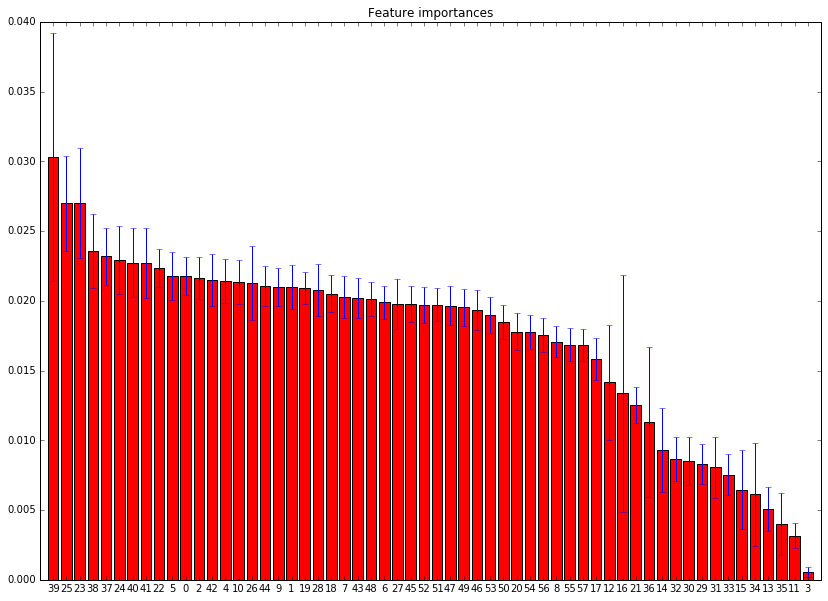

In [116]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
X = df[features]
y = df['shares']
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d - %s (%f) " % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [102]:
importances[indices[:5]]

array([ 0.03030539,  0.02698445,  0.0269827 ,  0.02358878,  0.02318772])

In [88]:
for f in range(5):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], features[indices[f]] ,importances[indices[f]]))

1. feature 39 LDA_02 (0.030305)
2. feature 25 kw_avg_avg (0.026984)
3. feature 23 kw_min_avg (0.026983)
4. feature 38 LDA_01 (0.023589)
5. feature 37 LDA_00 (0.023188)


In [141]:
best_features = []
for i in indices[:5]:
    best_features.append(features[i])

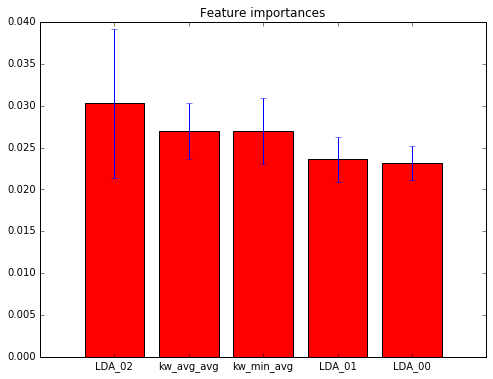

In [143]:
# Plot the top 5 feature importances of the forest
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(5), importances[indices][:5], 
       color="r",  yerr=std[indices][:5], align="center")
plt.xticks(range(5), best_features)
plt.xlim([-1, 5])
plt.show()

# Decision Tree accuracy and time elapsed caculation

In [8]:
t0=time()
print "DecisionTree"

#dt = DecisionTreeClassifier(min_samples_split=1,random_state=99)
dt = DecisionTreeClassifier(min_samples_split=20,max_depth=5,random_state=99)

clf_dt=dt.fit(X_train,y_train)

print "Acurracy: ", clf_dt.score(X_test,y_test)
t1=time()
print "time elapsed: ", t1-t0

DecisionTree
Acurracy:  0.638857359062
time elapsed:  0.859000205994


## cross validation for DT

In [9]:
tt0=time()
print "cross result========"
scores = cross_validation.cross_val_score(dt, df[features], df['shares'], cv=5)
print scores
print scores.mean()
tt1=time()
print "time elapsed: ", tt1-tt0
print "\n"

cross result========
[ 0.53272796  0.63463236  0.64749653  0.66048682  0.64984864]
0.625038462571
time elapsed:  6.19799995422




### Tuning our hyperparameters using GridSearch

In [146]:
from sklearn.metrics import classification_report

pipeline = Pipeline([
    ('clf', DecisionTreeClassifier(criterion='entropy'))
])

parameters = {
    'clf__max_depth': (5, 25 , 50),
    'clf__min_samples_split': (1, 5, 10),
    'clf__min_samples_leaf': (1, 2, 3)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1')
grid_search.fit(X_train, y_train)

print 'Best score: %0.3f' % grid_search.best_score_
print 'Best parameters set:'

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])

predictions = grid_search.predict(X_test)

print classification_report(y_test, predictions)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  4.5min finished


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best score: 0.662
Best parameters set:
	clf__max_depth: 5
	clf__min_samples_leaf: 5
	clf__min_samples_split: 1
             precision    recall  f1-score   support

          0       0.62      0.59      0.60      7427
          1       0.65      0.68      0.67      8431

avg / total       0.64      0.64      0.64     15858



# Random Forest accuracy and time elapsed caculation

In [20]:
t2=time()
print "RandomForest"
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
clf_rf = rf.fit(X_train,y_train)
print "Acurracy: ", clf_rf.score(X_test,y_test)
t3=time()
print "time elapsed: ", t3-t2

RandomForest
Acurracy:  0.660865178459
time elapsed:  4.992000103


## cross validation for RF

In [21]:
tt2=time()
print "cross result========"
scores = cross_validation.cross_val_score(rf, df[features], df['shares'], cv=5)
print scores
print scores.mean()
tt3=time()
print "time elapsed: ", tt3-tt2
print "\n"


cross result========
[ 0.56514062  0.64711817  0.66136966  0.67524278  0.66826438]
0.64342712232
time elapsed:  37.5399999619




### Receiver Operating Characteristic (ROC) curve

In [22]:
roc_auc_score(y_test,rf.predict(X_test))

0.65715936063854308

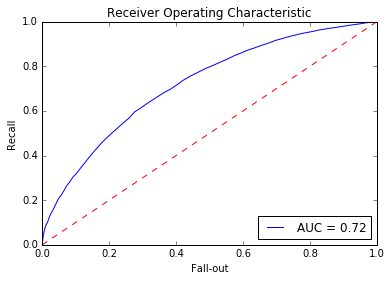

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = rf.predict_proba(X_test)

false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')

plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

### Tuning Models using GridSearch

In [24]:

pipeline2 = Pipeline([
('clf', RandomForestClassifier(criterion='entropy'))
])

parameters = {
    'clf__n_estimators': (5, 25, 50, 100),
    'clf__max_depth': (5, 25 , 50),
    'clf__min_samples_split': (1, 5, 10),
    'clf__min_samples_leaf': (1, 2, 3)
}

grid_search = GridSearchCV(pipeline2, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=3)

grid_search.fit(X_train, y_train)

print 'Best score: %0.3f' % grid_search.best_score_

print 'Best parameters set:'
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])

predictions = grid_search.predict(X_test)
print 'Accuracy:', accuracy_score(y_test, predictions)
print classification_report(y_test, predictions)
    

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 38.3min finished


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best score: 0.671
Best parameters set:
	clf__max_depth: 25
	clf__min_samples_leaf: 2
	clf__min_samples_split: 10
	clf__n_estimators: 100
Accuracy: 0.661748013621
             precision    recall  f1-score   support

          0       0.65      0.59      0.62      7427
          1       0.67      0.73      0.70      8431

avg / total       0.66      0.66      0.66     15858



## OOB Errors for Random Forests

C:\Miniconda2\lib\site-packages\sklearn\ensemble\forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


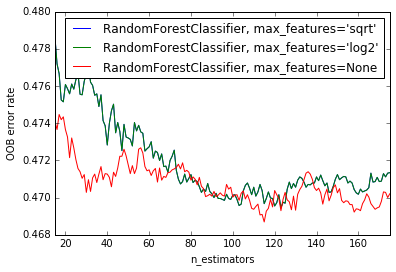

In [62]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

RANDOM_STATE = 123

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for paralellised ensembles but is necessary for tracking the OOB
# error trajectory during training.

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

# Naive Bayes accuracy and time elapsed caculation


In [16]:
t4=time()
print "NaiveBayes"
nb = BernoulliNB()
clf_nb=nb.fit(X_train,y_train)
print "Acurracy: ", clf_nb.score(X_test,y_test)
t5=time()
print "time elapsed: ", t5-t4

NaiveBayes
Acurracy:  0.612120065582
time elapsed:  0.230999946594


## cross-validation for NB

In [17]:
tt4=time()
print "cross result========"
scores = cross_validation.cross_val_score(nb, df[features], df['shares'], cv=5)
print scores
print scores.mean()
tt5=time()
print "time elapsed: ", tt5-tt4
print "\n"

cross result========
[ 0.59389583  0.59831     0.61760626  0.62517341  0.60443996]
0.607885091183
time elapsed:  1.18400001526




# KNN accuracy and time elapsed caculation

In [12]:
t6=time()
print "KNN"
# knn = KNeighborsClassifier(n_neighbors=3)
knn = KNeighborsClassifier()
clf_knn=knn.fit(X_train, y_train)
print "Acurracy: ", clf_knn.score(X_test,y_test) 
t7=time()
print "time elapsed: ", t7-t6

KNN
Acurracy:  0.57012233573
time elapsed:  6.75999999046


## cross validation for KNN

In [13]:
tt6=time()
print "cross result========"
scores = cross_validation.cross_val_score(knn, df[features], df['shares'], cv=5)
print scores
print scores.mean()
tt7=time()
print "time elapsed: ", tt7-tt6
print "\n"

cross result========
[ 0.53171901  0.52427797  0.56198764  0.56791525  0.56004036]
0.549188044908
time elapsed:  25.4110000134




In [25]:
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import grid_search

knn = KNeighborsClassifier()

parameters = {'n_neighbors': (10, 15, 25)}

grid = grid_search.GridSearchCV(knn, parameters, n_jobs=-1, verbose=1, scoring='accuracy')


grid.fit(X_train, y_train)

print 'Best score: %0.3f' % grid.best_score_

print 'Best parameters set:'
best_parameters = grid.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])
    
predictions = grid.predict(X_test)
print classification_report(y_test, predictions)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best score: 0.580
Best parameters set:
	n_neighbors: 25
             precision    recall  f1-score   support

          0       0.56      0.52      0.54      7427
          1       0.61      0.64      0.62      8431

avg / total       0.59      0.59      0.59     15858



[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   22.7s finished


# SVM accuracy and time elapsed caculation

In [ ]:
t7=time()
print "SVM"

svc = SVC()
clf_svc=svc.fit(X_train, y_train)
print "Acurracy: ", clf_svc.score(X_test,y_test) 
t8=time()
print "time elapsed: ", t8-t7

## cross validation for SVM

In [ ]:
tt7=time()
print "cross result========"
scores = cross_validation.cross_val_score(svc, df[features], df['shares'], cv=5)
print scores
print scores.mean()
tt8=time()
print "time elapsed: ", tt7-tt6
print "\n"

In [ ]:
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import grid_search

svc = SVC()

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

grid = grid_search.GridSearchCV(svc, parameters, n_jobs=-1, verbose=1, scoring='accuracy')


grid.fit(X_train, y_train)

print 'Best score: %0.3f' % grid.best_score_

print 'Best parameters set:'
best_parameters = grid.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])
    
predictions = grid.predict(X_test)
print classification_report(y_test, predictions)

In [ ]:
pipeline = Pipeline([
    ('clf', SVC(kernel='rbf', gamma=0.01, C=100))
])

parameters = {
    'clf__gamma': (0.01, 0.03, 0.1, 0.3, 1),
    'clf__C': (0.1, 0.3, 1, 3, 10, 30),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='accuracy')

grid_search.fit(X_train, y_train)

print 'Best score: %0.3f' % grid_search.best_score_

print 'Best parameters set:'
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])
    
predictions = grid_search.predict(X_test)
print classification_report(y_test, predictions)

___
# Ensemble Learning

In [43]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

## Combining different algorithms for classification with majority vote

In [15]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001, 
                          random_state=0)

clf2 = DecisionTreeClassifier(max_depth=5,
                              min_samples_leaf=5,
                              min_samples_split=1,
                              criterion='entropy', 
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1, 
                            p=2, 
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.70 (+/- 0.01) [Logistic Regression]
ROC AUC: 0.68 (+/- 0.01) [Decision Tree]
ROC AUC: 0.57 (+/- 0.01) [KNN]


You may be wondering why we trained the logistic regression and k-nearest neighbors classifier as part of a pipeline. The reason behind it is that, both the
logistic regression and k-nearest neighbors algorithms (using the Euclidean distance metric) are not scale-invariant in contrast with decision trees.

Now let's move on to the more exciting part and combine the individual classifiers for majority rule voting in our MajorityVoteClassifier:

In [18]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(
                classifiers=[pipe1, clf2])

clf_labels = ['Logistic Regression', 'Decision Tree', 'Majority Voting'] 
all_clf = [pipe1, clf2, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

ROC AUC: 0.70 (+/- 0.01) [Logistic Regression]
ROC AUC: 0.68 (+/- 0.01) [Decision Tree]
ROC AUC: 0.71 (+/- 0.01) [Majority Voting]


## Evaluating and tuning the ensemble classifier

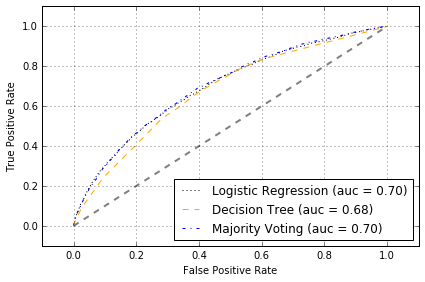

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, 
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, 
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, 
             color=clr, 
             linestyle=ls, 
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 
         linestyle='--', 
         color='gray', 
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

In [25]:
df.columns

Index([u'url', u'timedelta', u'n_tokens_title', u'n_tokens_content',
       u'n_unique_tokens', u'n_non_stop_words', u'n_non_stop_unique_tokens',
       u'num_hrefs', u'num_self_hrefs', u'num_imgs', u'num_videos',
       u'average_token_length', u'num_keywords', u'data_channel_is_lifestyle',
       u'data_channel_is_entertainment', u'data_channel_is_bus',
       u'data_channel_is_socmed', u'data_channel_is_tech',
       u'data_channel_is_world', u'kw_min_min', u'kw_max_min', u'kw_avg_min',
       u'kw_min_max', u'kw_max_max', u'kw_avg_max', u'kw_min_avg',
       u'kw_max_avg', u'kw_avg_avg', u'self_reference_min_shares',
       u'self_reference_max_shares', u'self_reference_avg_sharess',
       u'weekday_is_monday', u'weekday_is_tuesday', u'weekday_is_wednesday',
       u'weekday_is_thursday', u'weekday_is_friday', u'weekday_is_saturday',
       u'weekday_is_sunday', u'is_weekend', u'LDA_00', u'LDA_01', u'LDA_02',
       u'LDA_03', u'LDA_04', u'global_subjectivity',
       u'global_sen

In [32]:
X_2 = df[['LDA_02', 'kw_avg_avg']].values
y = df['shares'].values

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y,test_size=0.40, random_state=1)

In [34]:
clf1 = LogisticRegression(penalty='l2', 
                          C=0.001, 
                          random_state=0)

clf2 = DecisionTreeClassifier(max_depth=5,
                              min_samples_leaf=5,
                              min_samples_split=1,
                              criterion='entropy', 
                              random_state=0)

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])

# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(
                classifiers=[pipe1, clf2])

clf_labels = ['Logistic Regression', 'Decision Tree', 'Majority Voting'] 

print('10-fold cross validation:\n')

all_clf = [pipe1, clf2, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.62 (+/- 0.02) [Logistic Regression]
ROC AUC: 0.62 (+/- 0.02) [Decision Tree]
ROC AUC: 0.63 (+/- 0.02) [Majority Voting]


We selected two best features for the classification examples, it would be interesting to see what the decision region of the ensemble classifier actually looks like:

In [35]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

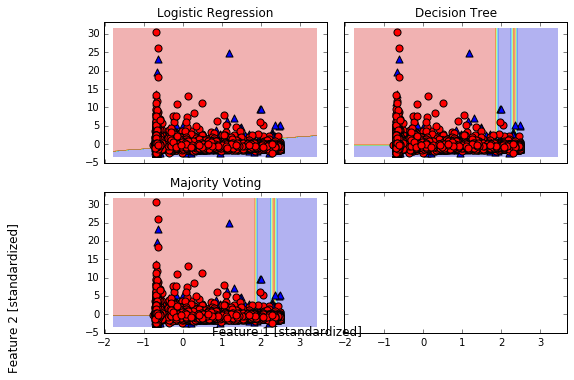

In [36]:
from itertools import product

all_clf = [pipe1, clf2, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(14, 9))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='red', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, 
         s='Feature 1 [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, 
         s='Feature 2 [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.tight_layout()
# plt.savefig('./figures/voting_panel', bbox_inches='tight', dpi=300)
plt.show()

## Plot class probabilities calculated by the VotingClassifier

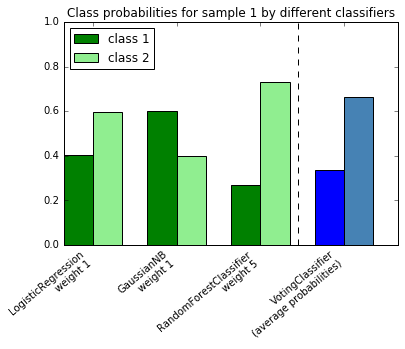

In [61]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(random_state=123)
clf2 = RandomForestClassifier(random_state=123)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                        voting='soft',
                        weights=[1, 1, 5])

# predict class probabilities for all classifiers
probas = [c.fit(X, y).predict_proba(X) for c in (clf1, clf2, clf3, eclf)]

# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]


# plotting

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width, color='green')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width, color='lightgreen')

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width, color='blue')
p4 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width, color='steelblue')

# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['LogisticRegression\nweight 1',
                    'GaussianNB\nweight 1',
                    'RandomForestClassifier\nweight 5',
                    'VotingClassifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')
plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.show()

In [36]:
# read .csv from provided dataset
csv_filename="datasets/OnlineNewsPopularity.csv"

# df=pd.read_csv(csv_filename,index_col=0)
df=pd.read_csv(csv_filename)

# handle goal attrubte to binary
popular = df.shares >= 1400
unpopular = df.shares < 1400
df.loc[popular,'shares'] = 1
df.loc[unpopular,'shares'] = 0

In [37]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731,12,219,0.663594,1.0,0.815385,4,2,1,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731,9,255,0.604743,1.0,0.791946,3,1,1,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0
2,http://mashable.com/2013/01/07/apple-40-billio...,731,9,211,0.575130,1.0,0.663866,3,1,1,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1
3,http://mashable.com/2013/01/07/astronaut-notre...,731,9,531,0.503788,1.0,0.665635,9,0,1,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.415646,1.0,0.540890,19,19,20,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0


In [38]:
features=list(df.columns[2:60])

# split dataset to 60% training and 40% testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(df[features], df['shares'], test_size=0.4, random_state=0)

In [39]:
print X_train.shape, y_train.shape

(23786, 58) (23786L,)


In [40]:
X = df[features]
y= df['shares']

In [49]:
clf1 = LogisticRegression(penalty='l2', 
                          C=0.001, 
                          random_state=0)

clf2 = DecisionTreeClassifier(max_depth=5,
                              min_samples_leaf=5,
                              min_samples_split=1,
                              criterion='entropy', 
                              random_state=0)

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])

# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(
                classifiers=[pipe1, clf2])

clf_labels = ['Logistic Regression', 'Decision Tree', 'Majority Voting'] 

print('10-fold cross validation:\n')

all_clf = [pipe1, clf2, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.70 (+/- 0.01) [Logistic Regression]
ROC AUC: 0.68 (+/- 0.01) [Decision Tree]
ROC AUC: 0.71 (+/- 0.01) [Majority Voting]


In [50]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
             max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
             min_samples_split=1, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_samples_leaf': 5,
 'decisiontreeclassifier__min_samples_split': 1,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=Tr

### Tuning using GridSearch:

In [52]:
from sklearn.grid_search import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf, 
                    param_grid=params, 
                    cv=10, 
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f+/-%0.2f %r"
            % (mean_score, scores.std() / 2, params))

0.697+/-0.01 {'decisiontreeclassifier__max_depth': 1, 'pipeline__clf__C': 0.001}
0.702+/-0.01 {'decisiontreeclassifier__max_depth': 1, 'pipeline__clf__C': 0.1}
0.702+/-0.01 {'decisiontreeclassifier__max_depth': 1, 'pipeline__clf__C': 100.0}
0.698+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline__clf__C': 0.001}
0.702+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline__clf__C': 0.1}
0.702+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline__clf__C': 100.0}


In [53]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline__clf__C': 0.1}
Accuracy: 0.70


## Bagging -- Building an ensemble of classifiers from bootstrap samples

Bagging is an ensemble learning technique that is closely related to the MajorityVoteClassifier,however, instead of using the same training set to fit the individual classifiers in the ensemble, we draw bootstrap samples (random samples with replacement) from the initial training set, which is why bagging is also known as bootstrap aggregating.

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=-1, 
                        random_state=1)

In [9]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.572
Bagging train/test accuracies 1.000/0.661


C:\Miniconda2\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
C:\Miniconda2\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
C:\Miniconda2\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
C:\Miniconda2\lib\site-packages

## Leveraging weak learners via adaptive boosting 

In [10]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=0)

In [11]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.596/0.597
AdaBoost train/test accuracies 0.675/0.662


## Two-class AdaBoost

C:\Miniconda2\lib\site-packages\ipykernel\__main__.py:53: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


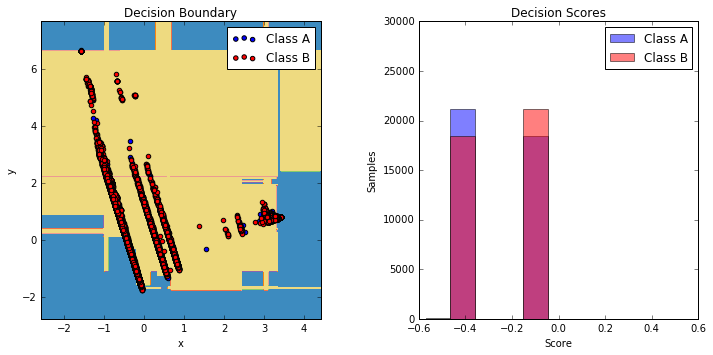

In [63]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles


# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(X, y)

plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5)
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

## Discrete versus Real AdaBoost

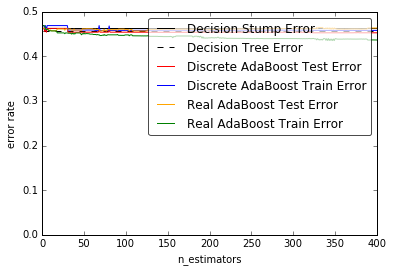

In [64]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier


n_estimators = 400
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = 1.


dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME")
ada_discrete.fit(X_train, y_train)

ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R")
ada_real.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, 'k-',
        label='Decision Stump Error')
ax.plot([1, n_estimators], [dt_err] * 2, 'k--',
        label='Decision Tree Error')

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train)

ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')
ax.plot(np.arange(n_estimators) + 1, ada_real_err,
        label='Real AdaBoost Test Error',
        color='orange')
ax.plot(np.arange(n_estimators) + 1, ada_real_err_train,
        label='Real AdaBoost Train Error',
        color='green')

ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

## Feature transformations with ensembles of trees

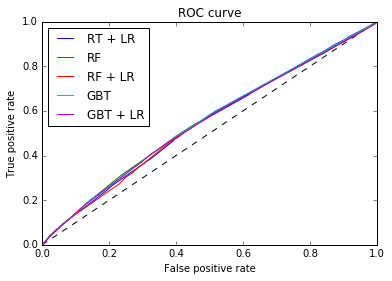

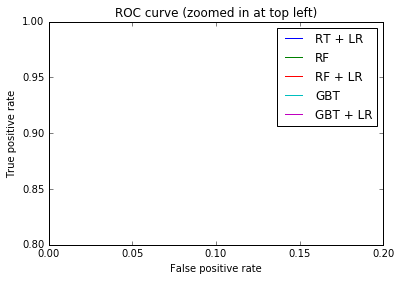

In [65]:
import numpy as np
np.random.seed(10)

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

n_estimator = 10
# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
	random_state=0)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)


# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)


# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# PCA Decomposition

In [19]:
target_names = ['Shares > 1400' , 'Shares < 1400']

In [41]:
X.values

array([[  1.20000000e+01,   2.19000000e+02,   6.63594467e-01, ...,
         -1.87500000e-01,   0.00000000e+00,   1.87500000e-01],
       [  9.00000000e+00,   2.55000000e+02,   6.04743081e-01, ...,
          0.00000000e+00,   5.00000000e-01,   0.00000000e+00],
       [  9.00000000e+00,   2.11000000e+02,   5.75129531e-01, ...,
          0.00000000e+00,   5.00000000e-01,   0.00000000e+00],
       ..., 
       [  1.00000000e+01,   4.42000000e+02,   5.16355139e-01, ...,
          1.36363636e-01,   4.54545450e-02,   1.36363636e-01],
       [  6.00000000e+00,   6.82000000e+02,   5.39493293e-01, ...,
          0.00000000e+00,   5.00000000e-01,   0.00000000e+00],
       [  1.00000000e+01,   1.57000000e+02,   7.01986750e-01, ...,
          2.50000000e-01,   1.66666667e-01,   2.50000000e-01]])

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X)

In [48]:
for a in [red_x, red_y,blue_x,blue_y]:
    print len(a)

18490
18490
21154
21154


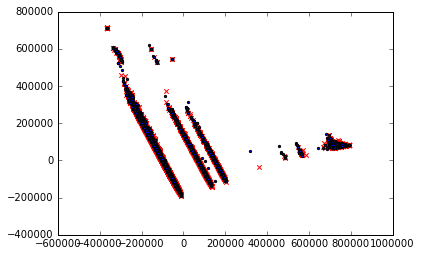

In [49]:
red_x, red_y = [], []
blue_x, blue_y = [], []

for i in range(len(reduced_X)):
    if y[i] == 0:
        red_x.append(reduced_X[i][0])
        red_y.append(reduced_X[i][1])
    elif y[i] == 1:
        blue_x.append(reduced_X[i][0])
        blue_y.append(reduced_X[i][1])
        
plt.scatter(red_x, red_y, c='r', marker='x')
plt.scatter(blue_x, blue_y, c='b', marker='.')
plt.show()

C:\Miniconda2\lib\site-packages\ipykernel\__main__.py:28: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Miniconda2\lib\site-packages\ipykernel\__main__.py:29: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Miniconda2\lib\site-packages\ipykernel\__main__.py:40: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


explained variance ratio (first two components): [ 0.7628241   0.16383047]


C:\Miniconda2\lib\site-packages\ipykernel\__main__.py:41: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


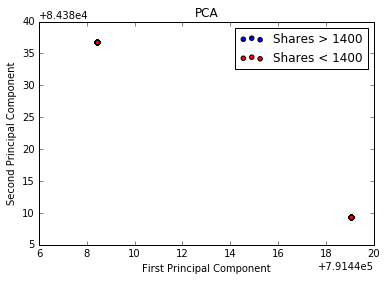

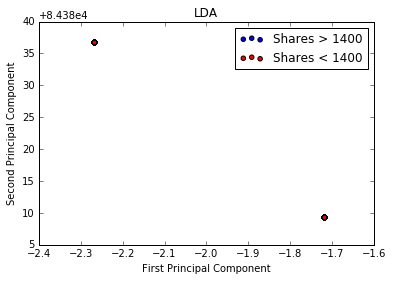

'\n\nfor c, i, target_name in zip("rb", [0, 1], target_names):\n    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, label=target_name)\nplt.legend()\nplt.title(\'PCA\')\n\nplt.figure()\nfor c, i, target_name in zip("rb", [0, 1], target_names):\n    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)\nplt.legend()\nplt.title(\'LDA\')\n\nplt.show()\n'

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
"""
pca = PCA(n_components=2)
X_r = pca.fit(X.values).transform(X.values)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X.values, y.values).transform(X.values)
"""
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))


plt.figure()

colors = ['blue','red']
for i in xrange(len(colors)):
    px = X_r[:, 0][y == i]
    py = X_r[:, 1][y == i]
    plt.scatter(px, py, c=colors[i])
plt.legend(target_names)
plt.title('PCA')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.figure()

colors = ['blue','red']
for i in xrange(len(colors)):
    px = X_r2[:, 0][y == i]
    py = X_pca[:, 1][y == i]
    plt.scatter(px, py, c=colors[i])
plt.legend(target_names)
plt.title('LDA')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.show()

"""

for c, i, target_name in zip("rb", [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('PCA')

plt.figure()
for c, i, target_name in zip("rb", [0, 1], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('LDA')

plt.show()
"""

In [25]:
plt.figure()
def plot_pca_scatter():
    colors = ['blue','red']
    for i in xrange(len(colors)):
        px = X_pca[:, 0][y == i]
        py = X_pca[:, 1][y == i]
        plt.scatter(px, py, c=colors[i])
    plt.legend(target_names)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')

In [26]:
from sklearn.decomposition import PCA


estimator = PCA(n_components=2)
X_pca = estimator.fit_transform(X.values)
plot_pca_scatter() # Note that we only plot the first and second principal component

C:\Miniconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Miniconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [ ]:
plt.figure(figsize=(2. * n_col, 2.26 * n_row))
for i, comp in enumerate(images):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(comp.reshape((8, 8)), interpolation='nearest')
    plt.text(0, -1, str(i + 1) + '-component')
    plt.xticks(())
    plt.yticks(())

___
# Optimization

## Concatenating multiple feature extraction methods


In [11]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

# This dataset is way to high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)

dt = DecisionTreeClassifier(min_samples_split=1,max_depth=5,min_samples_leaf=5,random_state=99)

# Do grid search over k, n_components and max_depth:

pipeline = Pipeline([("features", combined_features), ("dt", dt)])

param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  dt__max_depth=[3, 5, 7])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
grid_search.fit(X, y)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] features__pca__n_components=1, dt__max_depth=3, features__univ_select__k=1 
[CV]  features__pca__n_components=1, dt__max_depth=3, features__univ_select__k=1, score=0.555539 -   0.3s
[CV] features__pca__n_components=1, dt__max_depth=3, features__univ_select__k=1 
[CV]  features__pca__n_components=1, dt__max_depth=3, features__univ_select__k=1, score=0.595807 -   0.3s
[CV] features__pca__n_components=1, dt__max_depth=3, features__univ_select__k=1 
[CV]  features__pca__n_components=1, dt__max_depth=3, features__univ_select__k=1, score=0.572953 -   0.3s
[CV] features__pca__n_components=1, dt__max_depth=3, features__univ_select__k=2 
[CV]  features__pca__n_components=1, dt__max_depth=3, features__univ_select__k=2, score=0.565829 -   0.3s

[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    1.6s



[CV] features__pca__n_components=1, dt__max_depth=3, features__univ_select__k=2 
[CV]  features__pca__n_components=1, dt__max_depth=3, features__univ_select__k=2, score=0.594899 -   0.4s
[CV] features__pca__n_components=1, dt__max_depth=3, features__univ_select__k=2 
[CV]  features__pca__n_components=1, dt__max_depth=3, features__univ_select__k=2, score=0.595807 -   0.3s
[CV] features__pca__n_components=2, dt__max_depth=3, features__univ_select__k=1 
[CV]  features__pca__n_components=2, dt__max_depth=3, features__univ_select__k=1, score=0.554782 -   0.3s
[CV] features__pca__n_components=2, dt__max_depth=3, features__univ_select__k=1 
[CV]  features__pca__n_components=2, dt__max_depth=3, features__univ_select__k=1, score=0.595807 -   0.4s
[CV] features__pca__n_components=2, dt__max_depth=3, features__univ_select__k=1 
[CV]  features__pca__n_components=2, dt__max_depth=3, features__univ_select__k=1, score=0.573331 -   0.4s
[CV] features__pca__n_components=2, dt__max_depth=3, features__u

[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:    5.5s



[CV] features__pca__n_components=3, dt__max_depth=3, features__univ_select__k=1 
[CV]  features__pca__n_components=3, dt__max_depth=3, features__univ_select__k=1, score=0.563711 -   0.4s
[CV] features__pca__n_components=3, dt__max_depth=3, features__univ_select__k=1 
[CV]  features__pca__n_components=3, dt__max_depth=3, features__univ_select__k=1, score=0.595807 -   0.4s
[CV] features__pca__n_components=3, dt__max_depth=3, features__univ_select__k=1 
[CV]  features__pca__n_components=3, dt__max_depth=3, features__univ_select__k=1, score=0.571364 -   0.3s
[CV] features__pca__n_components=3, dt__max_depth=3, features__univ_select__k=2 
[CV]  features__pca__n_components=3, dt__max_depth=3, features__univ_select__k=2, score=0.600257 -   0.4s
[CV] features__pca__n_components=3, dt__max_depth=3, features__univ_select__k=2 
[CV]  features__pca__n_components=3, dt__max_depth=3, features__univ_select__k=2, score=0.594899 -   0.4s
[CV] features__pca__n_components=3, dt__max_depth=3, features__u

[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:    8.0s
[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:   11.4s



[CV] features__pca__n_components=2, dt__max_depth=5, features__univ_select__k=1 
[CV]  features__pca__n_components=2, dt__max_depth=5, features__univ_select__k=1, score=0.532309 -   0.4s
[CV] features__pca__n_components=2, dt__max_depth=5, features__univ_select__k=1 
[CV]  features__pca__n_components=2, dt__max_depth=5, features__univ_select__k=1, score=0.596035 -   0.4s
[CV] features__pca__n_components=2, dt__max_depth=5, features__univ_select__k=1 
[CV]  features__pca__n_components=2, dt__max_depth=5, features__univ_select__k=1, score=0.572120 -   0.4s
[CV] features__pca__n_components=2, dt__max_depth=5, features__univ_select__k=2 
[CV]  features__pca__n_components=2, dt__max_depth=5, features__univ_select__k=2, score=0.594658 -   0.4s
[CV] features__pca__n_components=2, dt__max_depth=5, features__univ_select__k=2 
[CV]  features__pca__n_components=2, dt__max_depth=5, features__univ_select__k=2, score=0.594899 -   0.4s
[CV] features__pca__n_components=2, dt__max_depth=5, features__u

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   15.2s
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:   20.2s



[CV] features__pca__n_components=1, dt__max_depth=7, features__univ_select__k=2 
[CV]  features__pca__n_components=1, dt__max_depth=7, features__univ_select__k=2, score=0.591267 -   0.5s
[CV] features__pca__n_components=1, dt__max_depth=7, features__univ_select__k=2 
[CV]  features__pca__n_components=1, dt__max_depth=7, features__univ_select__k=2, score=0.608597 -   0.4s
[CV] features__pca__n_components=2, dt__max_depth=7, features__univ_select__k=1 
[CV]  features__pca__n_components=2, dt__max_depth=7, features__univ_select__k=1, score=0.548956 -   0.5s
[CV] features__pca__n_components=2, dt__max_depth=7, features__univ_select__k=1 
[CV]  features__pca__n_components=2, dt__max_depth=7, features__univ_select__k=1, score=0.598002 -   0.4s
[CV] features__pca__n_components=2, dt__max_depth=7, features__univ_select__k=1 
[CV]  features__pca__n_components=2, dt__max_depth=7, features__univ_select__k=1, score=0.571666 -   0.5s
[CV] features__pca__n_components=2, dt__max_depth=7, features__u

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   25.7s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   28.9s finished



Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, n_components=3, whiten=False)), ('univ_select', SelectKBest(k=2, score_func=<function f_classif at 0x0000000006D019E8>))],
       transformer_weights=None)), ('dt', DecisionTreeClassifier(class_weight=None, cr...plit=1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=99, splitter='best'))])
0.605337503784


## Comparison of Calibration of Classifiers

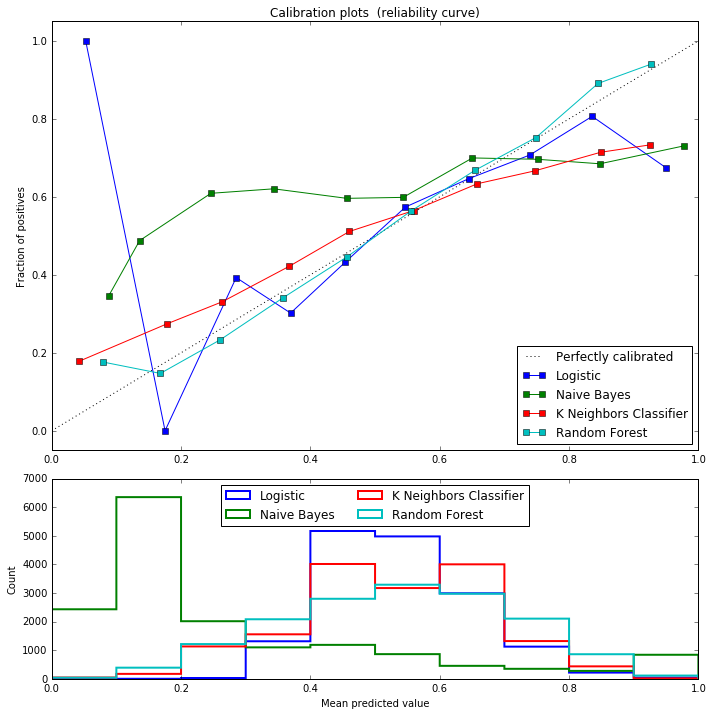

In [27]:
import numpy as np
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import calibration_curve

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=25)
rfc = RandomForestClassifier(n_estimators=100)


###############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (knn, 'K Neighbors Classifier'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

## Probability Calibration curves

Logistic:
	Brier: 0.238
	Precision: 0.598
	Recall: 0.690
	F1: 0.641

Naive Bayes:
	Brier: 0.324
	Precision: 0.676
	Recall: 0.223
	F1: 0.335

Naive Bayes + Isotonic:
	Brier: 0.236
	Precision: 0.610
	Recall: 0.714
	F1: 0.658

Naive Bayes + Sigmoid:
	Brier: 0.240
	Precision: 0.629
	Recall: 0.603
	F1: 0.615

Logistic:
	Brier: 0.238
	Precision: 0.598
	Recall: 0.690
	F1: 0.641

Decision Tree:
	Brier: 0.422
	Precision: 0.605
	Recall: 0.593
	F1: 0.599

Decision Tree + Isotonic:
	Brier: 0.241
	Precision: 0.581
	Recall: 0.819
	F1: 0.679

Decision Tree + Sigmoid:
	Brier: 0.241
	Precision: 0.579
	Recall: 0.811
	F1: 0.675



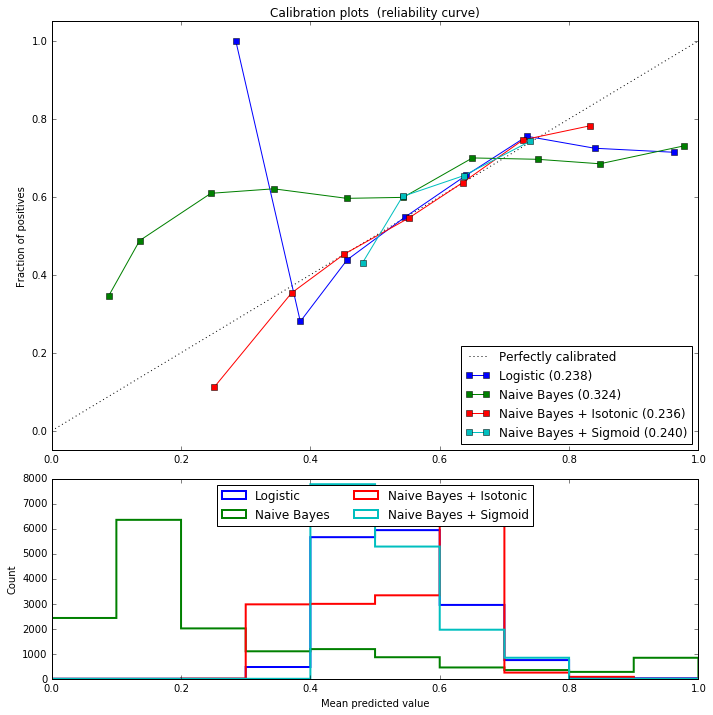

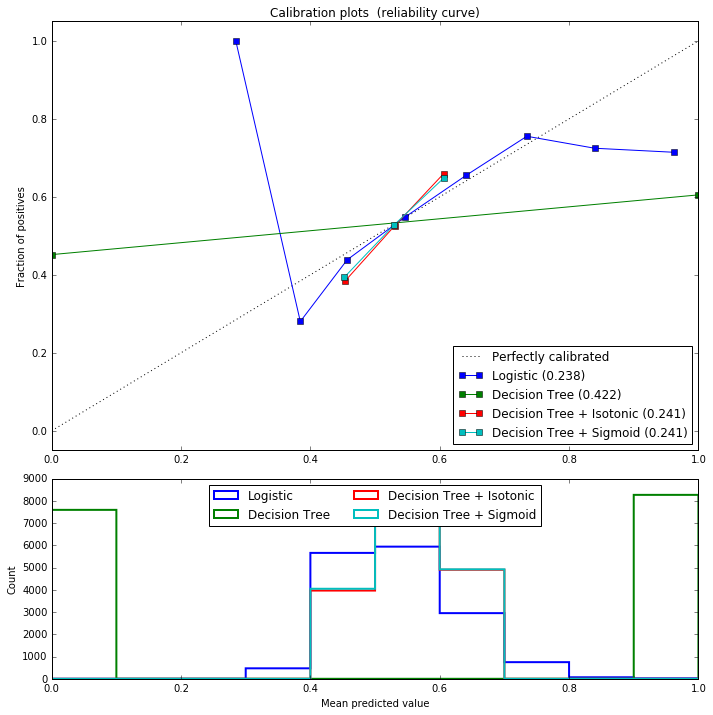

In [28]:

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.cross_validation import train_test_split



def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration cuve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration cuve for Linear SVC
plot_calibration_curve(DecisionTreeClassifier(), "Decision Tree", 2)

plt.show()

## Plot classification probability

classif_rate for K Nearest Neighbors : 76.077086 
classif_rate for L1 logistic : 53.309454 
classif_rate for L2 logistic : 52.103723 
classif_rate for Random Forest : 82.065382 
classif_rate for Decision Tree : 55.047422 


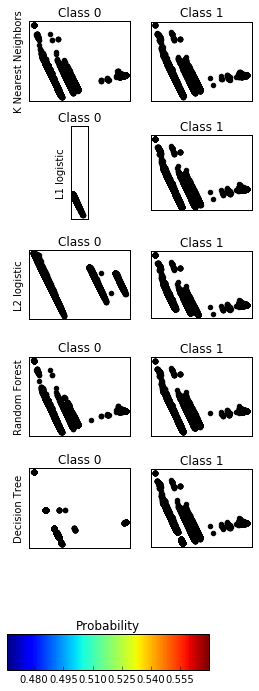

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

#PCA
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

n_features = X_r.shape[1]

C = 1.0

# Create different classifiers. The logistic regression cannot do
# multiclass out of the box.
classifiers = {'L1 logistic': LogisticRegression(C=C, penalty='l1'),
               'L2 logistic': LogisticRegression(C=C, penalty='l2'),
               'Decision Tree': DecisionTreeClassifier(max_depth=5,min_samples_leaf=5,min_samples_split=1,random_state=99),
               'K Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
               'Random Forest' : RandomForestClassifier(max_depth=25,min_samples_leaf=2,
                                                        min_samples_split=10,n_estimators=100,n_jobs=-1)
              }

n_classifiers = len(classifiers)

plt.figure(figsize=(2 * 2, n_classifiers * 2))
plt.subplots_adjust(bottom=.2, top=.95)

xx = np.linspace(3, 9, 100)
yy = np.linspace(1, 5, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]


for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_r, y)

    y_pred = classifier.predict(X_r)
    classif_rate = np.mean(y_pred.ravel() == y.ravel()) * 100
    print("classif_rate for %s : %f " % (name, classif_rate))

    # View probabilities=
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("Class %d" % k)
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                   extent=(3, 9, 1, 5), origin='lower')
        plt.xticks(())
        plt.yticks(())
        idx = (y_pred == k)
        if idx.any():
            plt.scatter(X_r[idx, 0], X_r[idx, 1], marker='o', c='k')

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

plt.show()

## Recursive feature elimination with cross-validation

Optimal number of features : 2


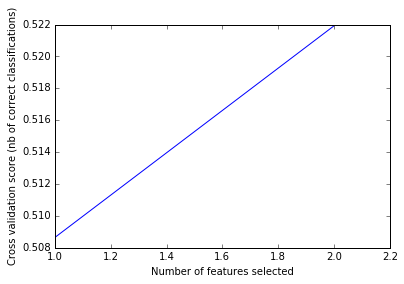

In [66]:
import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.

rf = RandomForestClassifier(max_depth=25,min_samples_leaf=2,min_samples_split=10,n_estimators=100,n_jobs=-1)

# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(y, 2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

___
# Regression

In [4]:
# read .csv from provided dataset
csv_filename="datasets/OnlineNewsPopularity.csv"

# df=pd.read_csv(csv_filename,index_col=0)
df=pd.read_csv(csv_filename)

In [5]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731,12,219,0.663594,1.0,0.815385,4,2,1,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731,9,255,0.604743,1.0,0.791946,3,1,1,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731,9,211,0.575130,1.0,0.663866,3,1,1,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731,9,531,0.503788,1.0,0.665635,9,0,1,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.415646,1.0,0.540890,19,19,20,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [6]:
features = df.columns[2:-1]

In [7]:
X = df[features]

In [8]:
y = df['shares']

In [9]:
# split dataset to 60% training and 40% testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size=0.4, random_state=0)

In [10]:
print X_train.shape, y_train.shape

(23786, 58) (23786L,)


In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import train_test_split
from sklearn. cross_validation import cross_val_score

from sklearn.feature_selection import *
from sklearn import metrics

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [12]:
# Scaling the features using StandardScaler:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train)
X_test = X_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

C:\Miniconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Miniconda2\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Miniconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Miniconda2\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data h

In [13]:
X.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,4.548239,...,0.353825,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064
std,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,0.844406,...,0.104542,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.478404,...,0.306244,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000
50%,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664082,...,0.358755,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000
75%,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,...,0.411428,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,8.041534,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000


In [14]:
# Scaling the features using StandardScaler:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y)

C:\Miniconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Miniconda2\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Miniconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Miniconda2\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data h

### Select K Best Features

[(False, 'n_tokens_title'), (False, 'n_tokens_content'), (False, 'n_unique_tokens'), (False, 'n_non_stop_words'), (False, 'n_non_stop_unique_tokens'), (False, 'num_hrefs'), (False, 'num_self_hrefs'), (False, 'num_imgs'), (False, 'num_videos'), (False, 'average_token_length'), (False, 'num_keywords'), (False, 'data_channel_is_lifestyle'), (False, 'data_channel_is_entertainment'), (False, 'data_channel_is_bus'), (False, 'data_channel_is_socmed'), (False, 'data_channel_is_tech'), (False, 'data_channel_is_world'), (False, 'kw_min_min'), (False, 'kw_max_min'), (False, 'kw_avg_min'), (False, 'kw_min_max'), (False, 'kw_max_max'), (False, 'kw_avg_max'), (False, 'kw_min_avg'), (True, 'kw_max_avg'), (True, 'kw_avg_avg'), (True, 'self_reference_min_shares'), (False, 'self_reference_max_shares'), (True, 'self_reference_avg_sharess'), (False, 'weekday_is_monday'), (False, 'weekday_is_tuesday'), (False, 'weekday_is_wednesday'), (False, 'weekday_is_thursday'), (False, 'weekday_is_friday'), (False, 'w

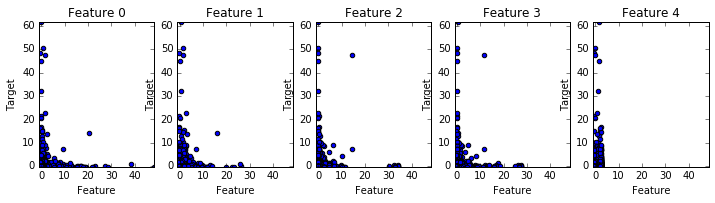

In [15]:
%matplotlib inline
from sklearn.feature_selection import *

fs=SelectKBest(score_func=f_regression,k=5)
X_new=fs.fit_transform(X_train,y_train)
features_zip = zip(fs.get_support(),features)
print features_zip

x_min, x_max = X_new[:,0].min(), X_new[:, 0].max()
y_min, y_max = y_train.min(), y_train.max()

fig=plt.figure()
#fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Two subplots, unpack the axes array immediately
fig, axes = plt.subplots(1,5)

fig.set_size_inches(12,12)

for i in range(5):
    axes[i].set_aspect('equal')
    axes[i].set_title('Feature ' + str(i))
    axes[i].set_xlabel('Feature')
    axes[i].set_ylabel('Target')
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_ylim(y_min, y_max)
    plt.sca(axes[i])
    plt.scatter(X_new[:,i],y_train)

In [16]:
best_features = []
for boolean,feature in features_zip:
    if boolean:
        best_features.append(feature)
best_features

['kw_max_avg',
 'kw_avg_avg',
 'self_reference_min_shares',
 'self_reference_avg_sharess',
 'LDA_03']

### Scatter Plot

In [17]:
# Scaling the features using StandardScaler:
df_scaler = StandardScaler()
df[df.columns[2:]] = df_scaler.fit_transform(df[df.columns[2:]])

In [18]:
cols = best_features + ['shares']

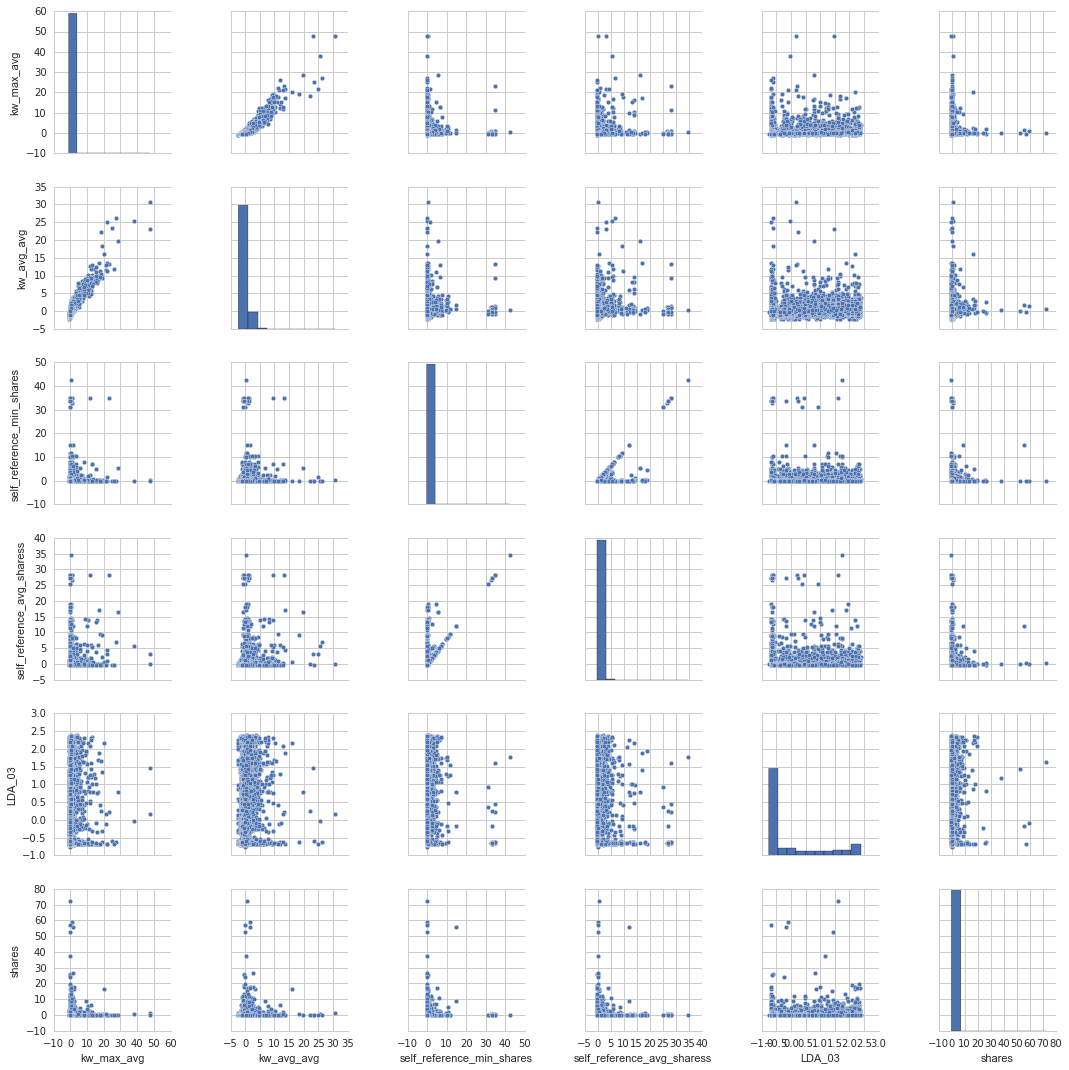

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

sns.pairplot(df[cols], size=2.5);
plt.tight_layout()
# plt.savefig('./figures/scatter.png', dpi=300)
plt.show()

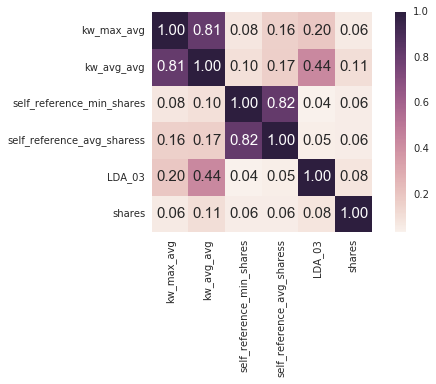

In [20]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm, 
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=cols,
            xticklabels=cols)

plt.tight_layout()
# plt.savefig('./figures/corr_mat.png', dpi=300)
plt.show()

In [21]:
# read .csv from provided dataset
csv_filename="datasets/OnlineNewsPopularity.csv"

# df=pd.read_csv(csv_filename,index_col=0)
df=pd.read_csv(csv_filename)

In [22]:
features = df.columns[2:-1]

In [23]:
X = df[features]

In [24]:
y = df['shares']

In [25]:
# split dataset to 60% training and 40% testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size=0.4, random_state=0)

In [26]:
print X_train.shape, y_train.shape

(23786, 58) (23786L,)


### Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

In [29]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 181358894.790, test: 1700598803470048768.000
R^2 train: 0.022, test: -28472172959.919


### Lasso Regression

In [30]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[  9.67891406e+01   4.44296065e-01   3.61892515e+03  -8.22074573e+02
  -2.13772910e+03   2.34614607e+01  -5.18091998e+01   1.76466228e+01
   5.57852453e+00  -2.71608071e+02   7.14479455e+01  -1.39340731e+03
  -1.21173084e+03  -7.23420147e+02  -7.28608253e+02  -4.67738423e+02
  -7.99261632e+02   6.52240623e-01   2.78920439e-02   7.25245368e-01
  -2.36302809e-03  -1.04966796e-03   7.49848442e-06  -3.94333058e-01
  -2.44257197e-01   1.79666394e+00   4.11541926e-02   1.22546275e-02
  -2.07448347e-02   5.07029841e+02  -2.51206149e+02   7.48146283e+01
  -1.49980732e+02  -1.43919882e+02   5.01553376e+02  -0.00000000e+00
   4.80469793e+01   4.32392378e+02  -4.06308185e+02  -3.67412375e+02
   1.75204540e+02   0.00000000e+00   2.35865194e+03   1.65504781e+03
  -1.20914269e+04  -0.00000000e+00   0.00000000e+00   4.97650996e+02
  -3.32887938e+03  -1.24619263e+03   9.75857923e+02  -3.33625671e+03
   3.64943996e+02   3.68421922e+02  -1.99245537e+02  -8.93416892e+01
   5.44375600e+02   7.76848258e+02

In [31]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 181370062.339, test: 63977156.347
R^2 train: 0.022, test: -0.071


### Ridge regression

In [32]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)
print(ridge.coef_)

[  9.73780586e+01   4.36544041e-01   3.49767737e+03  -1.49095688e+03
  -2.09082044e+03   2.37385133e+01  -5.20368662e+01   1.79212725e+01
   5.46130005e+00  -2.63157321e+02   7.09297312e+01  -1.40152716e+03
  -1.21196532e+03  -7.33679234e+02  -7.40750541e+02  -4.76721716e+02
  -8.00890156e+02   6.52819778e-01   2.78331400e-02   7.26658098e-01
  -2.36437330e-03  -1.04545866e-03   1.87826872e-05  -3.94501091e-01
  -2.43959781e-01   1.79437610e+00   4.11399968e-02   1.22455219e-02
  -2.06835372e-02   4.66297844e+02  -2.92834134e+02   3.38102437e+01
  -1.92373785e+02  -1.85658399e+02   3.37377723e+02  -1.66619493e+02
   1.70758230e+02   4.66763992e+02  -3.80509091e+02  -3.33639407e+02
   2.09296596e+02   3.80895428e+01   2.32905358e+03   1.39443932e+03
  -8.98867160e+03  -2.26401492e+03   5.56178006e+02   1.23650877e+03
  -3.16685456e+03  -1.21822479e+03   9.42136172e+02  -3.28740542e+03
   3.88834787e+02   3.37844161e+02  -2.07567356e+02  -9.24476601e+01
   5.62462449e+02   7.83841704e+02

In [33]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 181371135.654, test: 72440966.201
R^2 train: 0.022, test: -0.213


### ElasticNet Regression

In [34]:
from sklearn.linear_model import ElasticNet
en = ElasticNet(alpha=1.0, l1_ratio=0.5)
en.fit(X_train, y_train)
y_train_pred = en.predict(X_train)
y_test_pred = en.predict(X_test)
print(en.coef_)

[  7.33512666e+01   1.00865369e-01   1.85158201e-01  -9.58449799e+00
  -5.32287574e+00   3.00888804e+01  -4.28551721e+01   2.39598822e+01
   1.36469984e+01  -7.38064413e+01   8.44718841e+01  -5.95017569e+01
  -1.22345185e+02   1.64706321e+01   4.00714327e+00   5.74803075e+01
  -5.11154938e+01   8.73854947e-01   3.55357505e-02   6.83701509e-01
  -3.37738353e-03  -1.76445422e-03   1.56896288e-03  -4.83283418e-01
  -2.83216448e-01   2.09516907e+00   4.03846896e-02   1.10775596e-02
  -1.80477778e-02   1.11834657e+02  -7.64575273e+01   9.65874864e+00
  -5.32590449e+01  -3.72703669e+01   5.08410276e+01  -4.34749398e+00
   4.54935336e+01   2.38322141e+01  -4.63696731e+01  -4.88336520e+01
   6.31670896e+01   7.20402153e+00   3.21342258e+01  -1.09957900e+01
  -0.00000000e+00   0.00000000e+00  -1.33792358e+01   3.21075087e+00
  -8.68868477e+00  -1.06026257e+01   1.94126463e+01  -6.37015374e+01
  -7.60727219e+01  -3.29749944e+01   2.01857708e+01  -6.48900916e+00
   2.65515288e+01   4.16349025e+01

In [35]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 181740602.016, test: 58873606.287
R^2 train: 0.020, test: 0.014


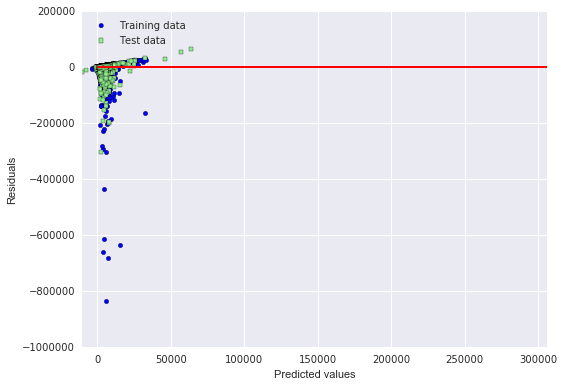

In [36]:
plt.scatter(y_train_pred,  y_train_pred - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=min(y_train.min(),y_test.min()), xmax=max(y_train.max(), y_test.max()), lw=2, color='red')
plt.xlim([min(y_test_pred.min(),y_test.min()), max(y_test_pred.max(), y_test.max())])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

## Decision tree regression

In [37]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 161962918.240, test: 61245914.862
R^2 train: 0.127, test: -0.025


---